In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
stock_symbol = 'INFY.NS'

In [4]:
df=yf.download(tickers = stock_symbol,period='5y',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [5]:
type(df)

pandas.core.frame.DataFrame

In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-22,688.700012,695.049988,673.799988,679.950012,588.052002,6672840
2018-10-23,675.950012,682.000000,653.299988,657.599976,568.722534,9041701
2018-10-24,663.000000,666.500000,647.150024,649.799988,561.976807,7058164
2018-10-25,643.000000,656.349976,636.250000,648.750000,567.178772,8270469
2018-10-26,645.299988,648.700012,629.900024,633.599976,553.933655,5464141


In [7]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-16,1432.099976,1443.599976,1430.000000,1434.150024,1434.150024,4850745
2023-10-17,1440.250000,1453.349976,1438.050049,1442.449951,1442.449951,3923764
2023-10-18,1442.000000,1454.000000,1438.349976,1440.550049,1440.550049,4264837
2023-10-19,1426.099976,1439.650024,1426.099976,1433.650024,1433.650024,6795691
2023-10-20,1430.000000,1438.500000,1425.250000,1429.949951,1429.949951,1985352


In [8]:
opn = df[['Open']]

<Axes: xlabel='Date'>

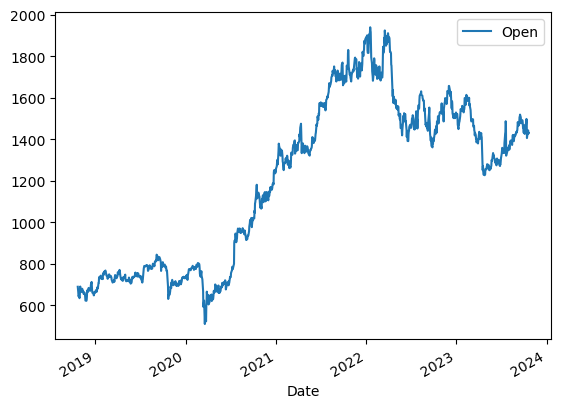

In [9]:
opn.plot()

In [10]:
ds = opn.values

In [11]:
ds

array([[ 688.70001221],
       [ 675.95001221],
       [ 663.        ],
       ...,
       [1442.        ],
       [1426.09997559],
       [1430.        ]])

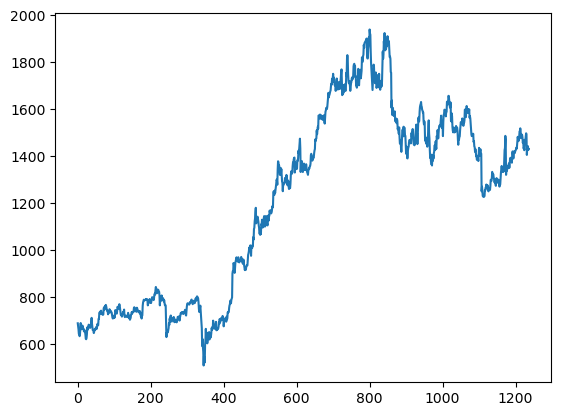

In [12]:
plt.plot(ds);

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [15]:
len(ds_scaled),len(ds)

(1237, 1237)

In [16]:
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled)- train_size

In [17]:
train_size,test_size

(865, 372)

In [18]:
ds_train,ds_test = ds_scaled[0:train_size,:],ds_scaled[train_size:len(ds_scaled),:1]

In [19]:
#creating dataset in timeseries for LSTM
def create_ds(dataset, step):
    xtrain,ytrain = [],[]
    for i in range (len(dataset)-step-1):
            a = dataset[i: (i+step),0]
            xtrain.append(a)
            ytrain.append(dataset[i+step,0])
    return np.array(xtrain), np.array(ytrain)     

In [20]:
#taking 100 days price as one record for training
time_stamp =100
x_train,y_train = create_ds(ds_train, time_stamp)
x_test,y_test = create_ds(ds_test, time_stamp)

In [21]:
x_train.shape,y_train.shape

((764, 100), (764,))

In [22]:
x_test.shape,y_test.shape

((271, 100), (271,))

In [23]:
#reshaping data to fit into LSTM model
x_train =x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test =x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [24]:
!pip install tensorflow

In [25]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [26]:
# creating LStm Model using Keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
#training model with adam optimizer and mean squared error loss function 
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=60)

Epoch 1/100
13/13 [==============================] - 13s 344ms/step - loss: 0.0713 - val_loss: 0.0184
Epoch 2/100
13/13 [==============================] - 2s 190ms/step - loss: 0.0109 - val_loss: 0.0118
Epoch 3/100
13/13 [==============================] - 2s 181ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 4/100
13/13 [==============================] - 2s 175ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 5/100
13/13 [==============================] - 2s 178ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 6/100
13/13 [==============================] - 2s 178ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 7/100
13/13 [==============================] - 2s 174ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 8/100
13/13 [==============================] - 2s 175ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 9/100
13/13 [==============================] - 2s 173ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 10/100
13/13 [==============================] - 2s 182ms/step - loss: 0.0016 - val_l

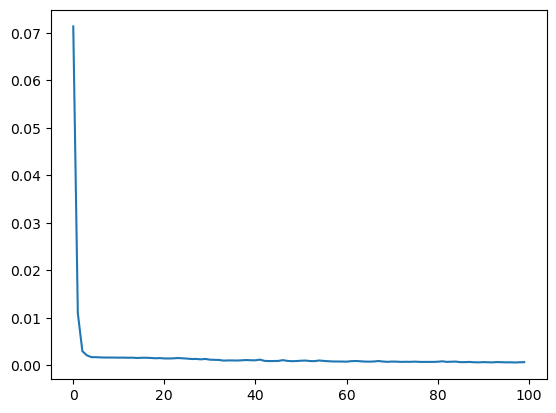

In [28]:
#plotting loss,it showthat loss has decreased  significantly any model trained well
loss=model.history.history['loss']
plt.plot(loss)

In [29]:
#predicting on train and test data
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

9/9 [==============================] - 0s 38ms/step


In [30]:
#inverse transform  to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

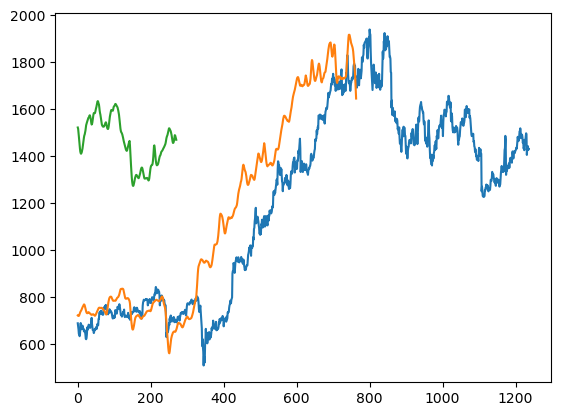

In [31]:
#comapring using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [32]:
type(train_predict)

numpy.ndarray

In [33]:
test = np.vstack((train_predict,test_predict))

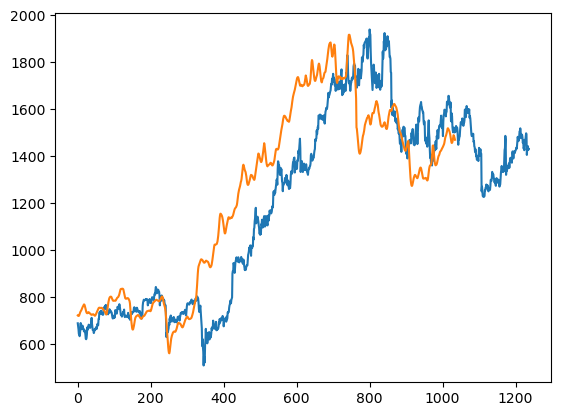

In [34]:
#combining the predicted  data to create  uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [35]:
len(ds_test)

372

In [36]:
#getting the last 100 days records
fut_inp = ds_test[270:]

In [37]:
fut_inp = fut_inp.reshape(1,-1)

In [38]:
#creating list iof the last 100 days
tmp_inp = list(fut_inp)
tmp_inp = tmp_inp[0].tolist()

In [44]:
#predicting next  30 days  price suing  the current data 
#it will predict in sliding window manner (algorithm) with stride 1
lst output=[]
n_steps=100
i=0
while(i<30)

     if(len(tmp_imp)>100):
        fut_inp =np.array(tmp_inp[1:])
        fut_inp =fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_shape,1))
        y_hat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(y_hat.tolist())
        lst_output.extend(y_hat.tolist())
        i=i+1
        
print(lst_output)
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 15)

In [45]:
import numpy as np  # You need to import NumPy to use it

lst_output = []
n_steps = 100  # Define n_steps
i = 0
tmp_inp = []  # Define tmp_inp before using it

# Initialize fut_inp (You need to define it before using it)
fut_inp = np.zeros(n_steps)

while i < 30:
    if len(tmp_inp) > 100:  # Check the length of tmp_inp
        fut_inp = np.array(tmp_inp[1:])
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
    else:
        fut_inp = fut_inp.reshape((1, n_steps, 1))  # Use n_steps here, not n_shape
        y_hat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(y_hat.tolist())
        lst_output.extend(y_hat.tolist())

    i = i + 1

print(lst_output)


[[0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139], [0.007627180777490139]]


In [46]:
len(ds_scaled)

1237

In [49]:
#craeting a graph for  one another
import numpy as np
plot_new = np.arange(1,101)
plot_pred = np.arange(101,131)

In [50]:
ds_new=ds_scaled.tolist()

In [51]:
len(ds)

1237

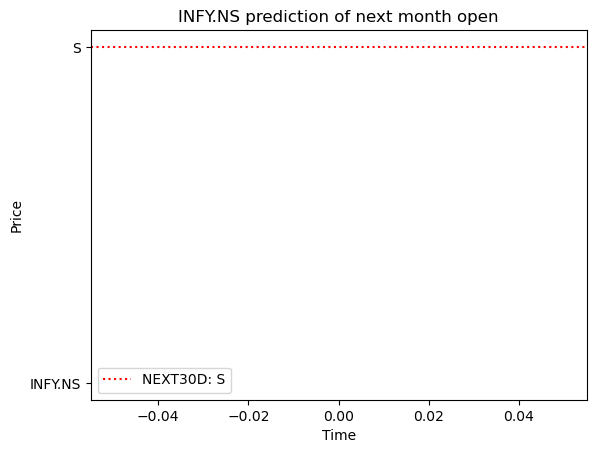

In [76]:
final_graph = stock_symbol
plt.plot(final_graph)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[-1], color='red', linestyle=':', label='NEXT30D: {0}'.format(final_graph[-1]))
plt.legend()